# XGBoost with VGG16 for Image Classification

# Import Libraries

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import tensorflow as tf

from PIL import Image
import cv2

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import xgboost

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load Data

**Citation** 
<br />
Huang, Mei-Ling; Chang, Ya-Han (2020), “Dataset of Tomato Leaves”, Mendeley Data, 
<br />
V1, doi: 10.17632/ngdgg79rzb.1

In [3]:
os.chdir("/kaggle/input/dataset-of-tomato-leaves/plant_village")
print(os.listdir())

TRAINING_DIR = os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/train')
VALIDATION_DIR = os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/val')
TESTING_DIR = os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/test')

['val', 'test', 'train']


In [4]:
IMG_SIZE = (224, 224)

In [5]:
train_images = []
train_labels = []

for directory_path in glob.glob('./train/*'):
    label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [6]:
val_images = []
val_labels = []

for directory_path in glob.glob('./val/*'):
    label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        val_images.append(img)
        val_labels.append(label)

val_images = np.array(val_images)
val_labels = np.array(val_labels)

In [7]:
test_images = []
test_labels = []

for directory_path in glob.glob('./test/*'):
    label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(label)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Encode Labels

In [8]:
le = preprocessing.LabelEncoder()

le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

le.fit(val_labels)
val_labels_encoded = le.transform(val_labels)

le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)

# Visualize Training Data for each Class

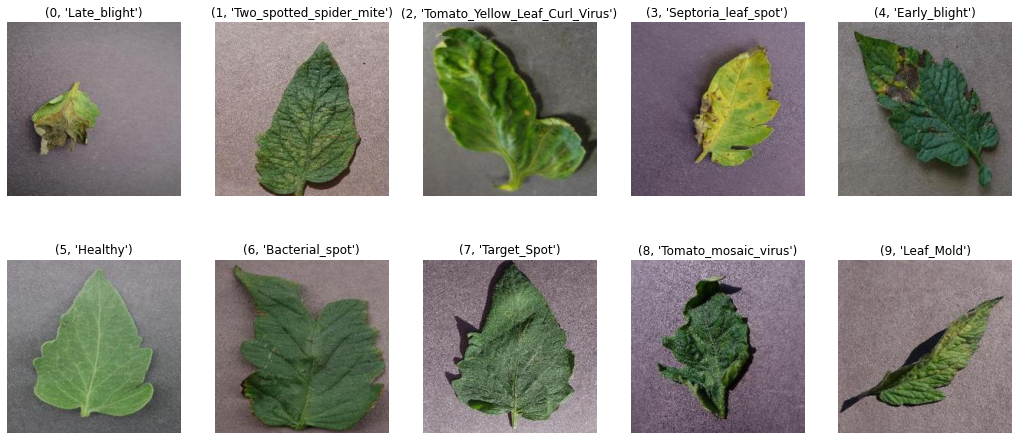

In [9]:
classes = os.listdir('./train')

plt.figure(figsize=(18,8))

for i in enumerate(classes):
    pic = os.listdir('./train/'+i[1])[0]
    image = Image.open('./train/'+i[1]+'/'+pic)
    image = np.asarray(image)
    plt.subplot(2, 5, i[0]+1)
    plt.title(i)
    plt.imshow(image)
    plt.axis("off")
plt.show()

# Data Summary

In [10]:
categories = []
train = []
val = []
test = []

folders = os.listdir('/kaggle/input/dataset-of-tomato-leaves/plant_village/train')
for f in folders:
    categories.append(f)
    train.append(len(os.listdir(os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/train', f))))

folders = os.listdir('/kaggle/input/dataset-of-tomato-leaves/plant_village/val')
for f in folders:
    val.append(len(os.listdir(os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/val', f))))

folders = os.listdir('/kaggle/input/dataset-of-tomato-leaves/plant_village/val')
for f in folders:
    test.append(len(os.listdir(os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/test', f))))

data_count = pd.DataFrame({'categories': categories,
                     'train': train,
                     'val': val,
                     'test': test                     
                    })

data_count

,categories,train,val,test
0,Late_blight,916,305,307
1,Two_spotted_spider_mite,804,268,269
2,Tomato_Yellow_Leaf_Curl_Virus,2571,857,858
3,Septoria_leaf_spot,850,283,284
4,Early_blight,480,160,160
5,Healthy,763,254,255
6,Bacterial_spot,1021,340,341
7,Target_Spot,674,224,226
8,Tomato_mosaic_virus,179,59,61
9,Leaf_Mold,457,152,153


In [11]:
os.chdir("/kaggle/working")
data_count.to_csv('data_count.csv', index=False)

In [12]:
del(train)
del(val)
del(test)
del(categories)

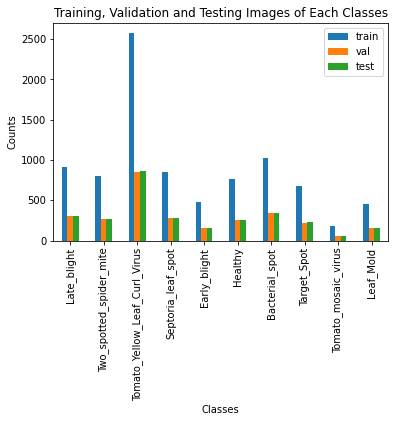

In [13]:
data_count.plot.bar(x='categories', title="Training, Validation and Testing Images of Each Classes")
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

# VGG16 for Feature Extraction

In [14]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

2022-09-22 18:36:31.322047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


   16384/58889256 [..............................] - ETA: 0s

2022-09-22 18:36:31.423430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 18:36:31.424328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 18:36:31.426121: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-22 18:36:31.426478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

58900480/58889256 [==============================] - 0s 0us/step


In [15]:
base_model.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Extract Features

In [16]:
train_features = base_model.predict(train_images)
train_features = train_features.reshape(train_features.shape[0], -1)
del(train_images)

val_features = base_model.predict(val_images)
val_features = val_features.reshape(val_features.shape[0], -1)
del(val_images)

2022-09-22 18:36:34.823683: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1311851520 exceeds 10% of free system memory.
2022-09-22 18:36:36.335960: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1311851520 exceeds 10% of free system memory.
2022-09-22 18:36:37.434761: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-22 18:36:38.565257: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-09-22 18:37:03.131600: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 874567680 exceeds 10% of free system memory.


# XGBoost Classifier

In [17]:
model = xgboost.XGBClassifier(learning_rate=0.1, n_estimators=120)

In [18]:
eval_set = [(train_features, train_labels_encoded), (val_features, val_labels_encoded)]

model.fit(
    train_features, 
    train_labels_encoded,  
    eval_metric=["merror"], 
    eval_set=eval_set, 
    verbose=True
)

[0]	validation_0-merror:0.17820	validation_1-merror:0.34769
[1]	validation_0-merror:0.12473	validation_1-merror:0.29187
[2]	validation_0-merror:0.09386	validation_1-merror:0.25879
[3]	validation_0-merror:0.07631	validation_1-merror:0.24673
[4]	validation_0-merror:0.06724	validation_1-merror:0.23535
[5]	validation_0-merror:0.05749	validation_1-merror:0.22812
[6]	validation_0-merror:0.05026	validation_1-merror:0.22192
[7]	validation_0-merror:0.04567	validation_1-merror:0.22123
[8]	validation_0-merror:0.03936	validation_1-merror:0.21606
[9]	validation_0-merror:0.03557	validation_1-merror:0.20986
[10]	validation_0-merror:0.03133	validation_1-merror:0.20503
[11]	validation_0-merror:0.02800	validation_1-merror:0.20124
[12]	validation_0-merror:0.02547	validation_1-merror:0.19883
[13]	validation_0-merror:0.02283	validation_1-merror:0.19297
[14]	validation_0-merror:0.02146	validation_1-merror:0.18884
[15]	validation_0-merror:0.01974	validation_1-merror:0.18711
[16]	validation_0-merror:0.01733	v

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=120,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

# Retrieve Performance Metrics

In [19]:
results = model.evals_result()

In [20]:
train_error = results['validation_0']['merror']
train_acc = [1.0 - i for i in train_error]

val_error = results['validation_1']['merror']
val_acc = [1.0 - i for i in val_error]

In [21]:
best_ntree_limit = model.best_ntree_limit
print('Best ntree limit: ', best_ntree_limit)

Best ntree limit:  120


# Plot Learning Curves

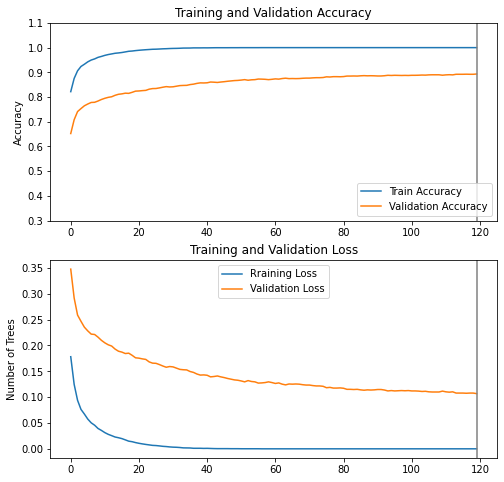

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.3,1.1])
plt.axvline(best_ntree_limit-1, color="gray", label="Optimal tree number")
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_error, label='Rraining Loss')
plt.plot(val_error, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.axvline(best_ntree_limit-1, color="gray", label="Optimal tree number")
plt.ylabel('merror')
plt.ylabel('Number of Trees')

plt.show()

In [23]:
train_predictions = model.predict(train_features)
val_predictions = model.predict(val_features)

print ("Training Accuracy = ", accuracy_score(train_labels_encoded, train_predictions))
print ("Validation Accuracy = ", accuracy_score(val_labels_encoded, val_predictions))

Training Accuracy =  1.0
Validation Accuracy =  0.8931771192281185


In [24]:
del(model)

# Train the Model with Best Parameters

In [25]:
model = xgboost.XGBClassifier(learning_rate=0.1, n_estimators=best_ntree_limit)

model.fit(
    train_features, 
    train_labels_encoded,  
    eval_metric=["merror"], 
    eval_set=eval_set, 
    verbose=True
)

[0]	validation_0-merror:0.17820	validation_1-merror:0.34769
[1]	validation_0-merror:0.12473	validation_1-merror:0.29187
[2]	validation_0-merror:0.09386	validation_1-merror:0.25879
[3]	validation_0-merror:0.07631	validation_1-merror:0.24673
[4]	validation_0-merror:0.06724	validation_1-merror:0.23535
[5]	validation_0-merror:0.05749	validation_1-merror:0.22812
[6]	validation_0-merror:0.05026	validation_1-merror:0.22192
[7]	validation_0-merror:0.04567	validation_1-merror:0.22123
[8]	validation_0-merror:0.03936	validation_1-merror:0.21606
[9]	validation_0-merror:0.03557	validation_1-merror:0.20986
[10]	validation_0-merror:0.03133	validation_1-merror:0.20503
[11]	validation_0-merror:0.02800	validation_1-merror:0.20124
[12]	validation_0-merror:0.02547	validation_1-merror:0.19883
[13]	validation_0-merror:0.02283	validation_1-merror:0.19297
[14]	validation_0-merror:0.02146	validation_1-merror:0.18884
[15]	validation_0-merror:0.01974	validation_1-merror:0.18711
[16]	validation_0-merror:0.01733	v

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=120,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [26]:
os.chdir("/kaggle/input/dataset-of-tomato-leaves/plant_village")

CLASSES = []

folders = os.listdir(TESTING_DIR)
for f in folders:
    CLASSES.append(f)
    
CLASSES

['Late_blight',
 'Two_spotted_spider_mite',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Septoria_leaf_spot',
 'Early_blight',
 'Healthy',
 'Bacterial_spot',
 'Target_Spot',
 'Tomato_mosaic_virus',
 'Leaf_Mold']

# Prediction and Evaluation

In [27]:
test_features = base_model.predict(test_images)
test_features = test_features.reshape(test_features.shape[0], -1)
del(test_images)

In [28]:
predictions = model.predict(test_features)

Evaluating the Algorithm

Accuracy: 		 0.8970487302676733
Precision: 		 0.8954671616329849
Recall: 		 0.8970487302676733
F1 score: 		 0.8970487302676733 



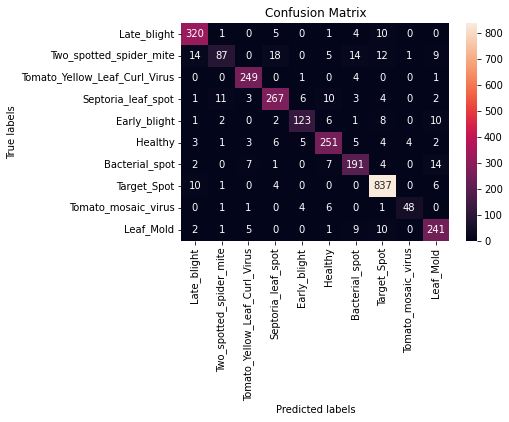

In [29]:
print('Evaluating the Algorithm\n')
print('Accuracy: \t\t', accuracy_score(test_labels_encoded, predictions))
print('Precision: \t\t', precision_score(test_labels_encoded, predictions, average='weighted'))
print('Recall: \t\t', recall_score(test_labels_encoded, predictions, average='weighted'))
print('F1 score: \t\t', f1_score(test_labels_encoded, predictions, average='micro'), '\n')

# Confusion Matrix
cf = tf.math.confusion_matrix(labels=test_labels_encoded, predictions=predictions).numpy()

ax= plt.subplot()
sns.heatmap(cf, annot=True, fmt='g', ax=ax);

ax.set_title('Confusion Matrix'); 

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 

ax.xaxis.set_ticklabels(CLASSES); 
ax.yaxis.set_ticklabels(CLASSES);

plt.xticks(rotation = 90)
plt.yticks(rotation = 360)

plt.show()

# Save the Model

In [30]:
os.chdir('/kaggle/working')
model.save_model('xbg_model.json')